tgb - 8/13/2019 - Drafting the figures for the manuscript

# 0) Initialization

In [1]:
import util.Landau_Potential_Diffusion as Landau
import util.curvature as curve
import util.pdf as PDF

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import datetime
import pickle
from skimage import measure
from scipy import ndimage
import scipy.integrate as sin
from scipy.optimize import curve_fit
import matplotlib as mpl

In [2]:
fz = 15
lw = 3
siz = 10

Using the 506x506 simulation for consistency with Dave's work

In [3]:
path = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_506x506/output/'

In [4]:
RCE300 = xr.open_mfdataset(path+'lfff????????.nc')

/users/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/users/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [5]:
RCE300

<xarray.Dataset>
Dimensions:       (bnds: 2, level1: 75, rlat: 506, rlon: 506, soil1: 10, srlat: 506, srlon: 506, time: 2400)
Coordinates:
  * rlon          (rlon) float32 0.0 0.03 0.06 ... 15.089999 15.12 15.15
  * rlat          (rlat) float32 0.0 0.03 0.06 ... 15.089999 15.12 15.15
  * srlon         (srlon) float32 0.015 0.044999998 ... 15.135 15.165
  * srlat         (srlat) float32 0.015 0.044999998 ... 15.135 15.165
    lon           (rlat, rlon) float32 -5.008956e-06 0.029994989 ... 15.149995
    lat           (rlat, rlon) float32 -2.504478e-06 ... 15.149999
    height_2m     float32 2.0
    height_toa    float32 33250.0
  * soil1         (soil1) float32 0.005 0.025 0.07 0.16 ... 1.47 2.86 5.74 11.5
  * time          (time) datetime64[ns] 2011-07-12T12:00:00 ... 2011-10-20T11:00:00
Dimensions without coordinates: bnds, level1
Data variables:
    time_bnds     (time, bnds) datetime64[ns] dask.array<shape=(2400, 2), chunksize=(1, 2)>
    rotated_pole  (time) |S1 b'' b'' b'' b'' b''

In [6]:
dt = 3600; # Timestep in seconds
tcoor = dt*np.arange(0,RCE300.time.shape[0])

tgb - 11/19/2019 - Below is for MSE 50th percentile

In [8]:
t_range = np.arange(0,np.size(RCE300.time)-2)
dMSE_dt = (RCE300.FMSE.values[t_range+2,:,:]-RCE300.FMSE.values[t_range,:,:])/(2*dt)
dMSE_dt = np.concatenate((dMSE_dt[0:1,:,:],dMSE_dt,np.tile(dMSE_dt[-1,:,:],(1,1,1))),axis=0)

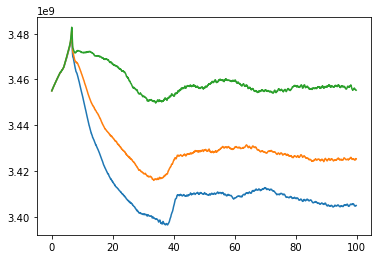

In [7]:
it = np.arange(0,2397)

plt.plot(tcoor[it]/(24*3600),np.percentile(a=RCE300.FMSE[it,:,:],q=25,axis=(1,2)))
plt.plot(tcoor[it]/(24*3600),np.percentile(a=RCE300.FMSE[it,:,:],q=50,axis=(1,2)))
plt.plot(tcoor[it]/(24*3600),np.percentile(a=RCE300.FMSE[it,:,:],q=75,axis=(1,2)))

tgb - 11/19/2019 - Below is code for CWV 48mm

In [7]:
t_range = np.arange(0,np.size(RCE300.time)-2)
dTQV_dt = (RCE300.TQV.values[t_range+2,:,:]-RCE300.TQV.values[t_range,:,:])/(2*dt)
dTQV_dt = np.concatenate((dTQV_dt[0:1,:,:],dTQV_dt,np.tile(dTQV_dt[-1,:,:],(1,1,1))),axis=0)

tgb - 11/19/2019 - Now for CWV 48mm contour and mapping it to a percentile

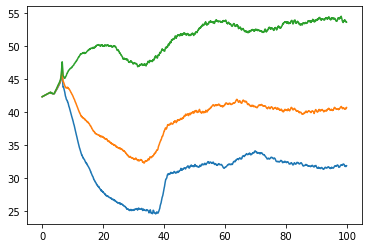

In [8]:
it = np.arange(0,2397)

plt.plot(tcoor[it]/(24*3600),np.percentile(a=RCE300.TQV[it,:,:],q=25,axis=(1,2)))
plt.plot(tcoor[it]/(24*3600),np.percentile(a=RCE300.TQV[it,:,:],q=50,axis=(1,2)))
plt.plot(tcoor[it]/(24*3600),np.percentile(a=RCE300.TQV[it,:,:],q=75,axis=(1,2)))

tgb - 11/19/2019 - Find percentile corresponding to 48mm

In [9]:
it = np.arange(2000,2100)
import scipy.stats as sstat
sstat.percentileofscore(a=RCE300.TQV[it,:,:].values.flatten(),score=48,kind='rank')

66.81110468840319

In [10]:
Perc48 = np.zeros((2397,))
for it in range(2397):
    print('it=',it,'/2397','              ',end='\r')
    Perc48[it] = sstat.percentileofscore(a=RCE300.TQV[it,:,:].values.flatten(),score=48,kind='rank')

Text(0.5, 1.0, 'Mean is 72.12216635380977%')

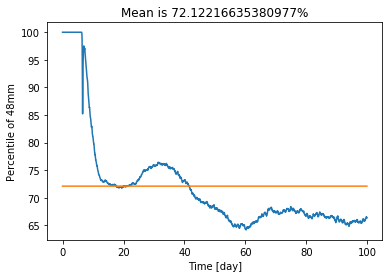

In [11]:
plt.plot(tcoor[np.arange(0,2397)]/(24*3600),Perc48)
plt.plot(tcoor[np.arange(0,2397)]/(24*3600),np.mean(Perc48)*Perc48**0)
plt.ylabel('Percentile of 48mm')
plt.xlabel('Time [day]')
MeanPerc48 = np.mean(Perc48)
plt.title('Mean is '+str(MeanPerc48)+'%')

# 1) Figure 1a = PDF CWV at different times

Chose days based on spinup, coalescence and coarsening phases and RGB codes defined by Dave

In [12]:
SPINstart = 0 #days
COALstart = 11 #days
COARstart = 25 #days
ENDstart = 85 # days

SPINrgb = np.array([255,126,14])/255
COALrgb = np.array([43,160,43])/255
COARrgb = np.array([31,119,179])/255

In [13]:
CWV_PDF_SPIN,SPINedges = np.histogram(RCE300.TQV[:(24*COALstart),:,:],bins=100,density=True)
CWV_PDF_COAL,COALedges = np.histogram(RCE300.TQV[(24*COALstart):(24*COARstart),:,:],bins=100,density=True)
CWV_PDF_COAR,COARedges = np.histogram(RCE300.TQV[(24*ENDstart):,:,:],bins=100,density=True)

In [12]:
# Bin daily to put uncertainty bounds on PDF
# Spinup phase
day = SPINstart
for i in range(11):
    print('i=',i,' & day=',day,'              ',end='\r')
    PDFtmp,tmp = np.histogram(RCE300.TQV[(24*day):(24*(day+1)),:,:],bins=SPINedges,density=True)
    day += 1
    if i==0: SPIN_min = PDFtmp; SPIN_max = PDFtmp;
    else: SPIN_min = np.minimum(SPIN_min,PDFtmp); SPIN_max = np.maximum(SPIN_max,PDFtmp)
# Coalescence phase
day = COALstart
for i in range(14):
    print('i=',i,' & day=',day,'              ',end='\r')
    PDFtmp,tmp = np.histogram(RCE300.TQV[(24*day):(24*(day+1)),:,:],bins=COALedges,density=True)
    day += 1
    if i==0: COAL_min = PDFtmp; COAL_max = PDFtmp;
    else: COAL_min = np.minimum(COAL_min,PDFtmp); COAL_max = np.maximum(COAL_max,PDFtmp)
# Coarsening phase
day = ENDstart
for i in range(15):
    print('i=',i,' & day=',day,'              ',end='\r')
    PDFtmp,tmp = np.histogram(RCE300.TQV[(24*day):np.minimum(2397,(24*(day+1))),:,:],bins=COARedges,density=True)
    day += 1
    if i==0: COAR_min = PDFtmp; COAR_max = PDFtmp;
    else: COAR_min = np.minimum(COAR_min,PDFtmp); COAR_max = np.maximum(COAR_max,PDFtmp)

tgb - 11/19/2019 - Calculates averaged value [mm] for the mean percentile that was chosen to be close to 48mm. That value should not be too far from 48mm and will be used in Figure 1a and to calculate MMLI down the line

In [13]:
SPIN_P48 = np.percentile(a=RCE300.TQV[:(24*COALstart),:,:],q=MeanPerc48,axis=(1,2))
COAL_P48 = np.percentile(a=RCE300.TQV[(24*COALstart):(24*COARstart),:,:],q=MeanPerc48,axis=(1,2))
COAR_P48 = np.percentile(a=RCE300.TQV[(24*ENDstart):,:,:],q=MeanPerc48,axis=(1,2))

Text(0.5, 0, 'Indices')

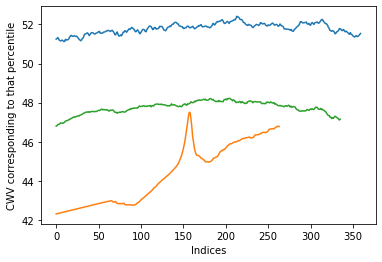

In [14]:
plt.plot(SPIN_P48,color=SPINrgb)
plt.plot(COAL_P48,color=COALrgb)
plt.plot(COAR_P48,color=COARrgb)
plt.ylabel('CWV corresponding to that percentile')
plt.xlabel('Indices')

In [15]:
SPIN_P48_mean = np.mean(SPIN_P48)
COAL_P48_mean = np.mean(COAL_P48)
COAR_P48_mean = np.mean(COAR_P48)

In [14]:
def edgTObin(edges):
    return 0.5*(edges[1:]+edges[:-1])

In [25]:
# Save reduced data
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
hf = open(pathPKL+'2019_11_19_Fig1a.pkl','wb')
Fig1a = {"SPINedges" : SPINedges,
         "SPIN_min" : SPIN_min,
         "SPIN_max" : SPIN_max,
         "SPINrgb" : SPINrgb,
         "COALedges" : COALedges,
         "COAL_min" : COAL_min,
         "COAL_max" : COAL_max,
         "COALrgb" : COALrgb,
         "COARedges" : COARedges,
         "COAR_min" : COAR_min,
         "COAR_max" : COAR_max,
         "COARrgb" : COARrgb,
         "CWV_PDF_SPIN": CWV_PDF_SPIN,
         "CWV_PDF_COAL": CWV_PDF_COAL,
         "CWV_PDF_COAR": CWV_PDF_COAR,
         "SPIN_P48_mean": SPIN_P48_mean,
         "COAL_P48_mean": COAL_P48_mean,
         "COAR_P48_mean": COAR_P48_mean
        }
pickle.dump(Fig1a,hf)
hf.close()

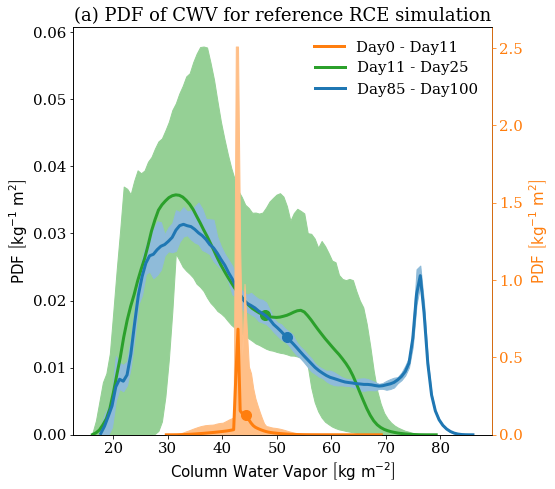

In [24]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
mpl.rcParams['lines.markersize'] = siz
plt.close('all')

fig,ax = plt.subplots(figsize=(7.5,7.5))
ax2 = ax.twinx()

# Shading goes in the back
ax2.fill_between(edgTObin(SPINedges),SPIN_min,SPIN_max,color=1-(1-SPINrgb)/2)
ax.fill_between(edgTObin(COALedges),COAL_min,COAL_max,color=1-(1-COALrgb)/2)
ax.fill_between(edgTObin(COARedges),COAR_min,COAR_max,color=1-(1-COARrgb)/2)

# Right axis = Day 11-100
SPINline = ax2.plot(edgTObin(SPINedges),CWV_PDF_SPIN,color=SPINrgb,label='Day0 - Day11')
# Add dots to indicate mean value of percentile chosen for MMLi
ax2.scatter(x=SPIN_P48_mean,y=np.interp(x=SPIN_P48_mean,xp=edgTObin(SPINedges),fp=CWV_PDF_SPIN),color=SPINrgb)

ax2.set_ylabel(r'$\mathrm{PDF\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$',color=SPINrgb)
ax2.spines['right'].set_color(SPINrgb)
ax2.tick_params(axis='y', colors=SPINrgb)
ax2.set_ylim((0,ax2.get_ylim()[1]))
leg2 = ax2.legend(frameon=False,bbox_to_anchor=(0,0,0.95,1))

# Left axis = Day0-Day11
COALline = ax.plot(edgTObin(COALedges),CWV_PDF_COAL,color=COALrgb,label='Day11 - Day25')
COARline = ax.plot(edgTObin(COARedges),CWV_PDF_COAR,color=COARrgb,label='Day85 - Day100')
# Add dots to indicate mean value of percentile chosen for MMLi
ax.scatter(x=COAL_P48_mean,y=np.interp(x=COAL_P48_mean,xp=edgTObin(COALedges),fp=CWV_PDF_COAL),color=COALrgb)
ax.scatter(x=COAR_P48_mean,y=np.interp(x=COAR_P48_mean,xp=edgTObin(COARedges),fp=CWV_PDF_COAR),color=COARrgb)

leg = ax.legend(frameon=False,bbox_to_anchor=(0,0,1,0.95))
ax.set_xlabel(r'$\mathrm{Column\ Water\ Vapor\ }\left[\mathrm{kg\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{PDF\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$')
ax.set_ylim((0,ax.get_ylim()[1]))
ax.set_title('(a) PDF of CWV for reference RCE simulation')

plt.draw()

# Save figure
path_home = '/users/tbeucler/'
plt.savefig(path_home+'Fig1a.pdf',format='pdf')

# 2) Figure 2a/c = Potential, Landau, Contour

## 2.1) Using MSE 50th percentile

Define value of zero potential; use median value of last week of FMSE.

In [9]:
bin0=np.percentile(a=RCE300.FMSE[-24*7:,:,:],q=50,axis=(0,1,2))

Use the bin edges of the coarsened PDF to calculate the potential and Landau free energy

In [10]:
F,binm,V = Landau.Landau_energy(RCE300.FMSE,dMSE_dt,bin0,N_bins=30)

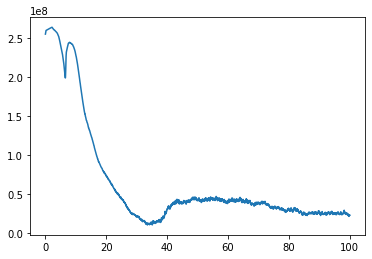

In [11]:
plt.plot(tcoor/(24*3600),F)

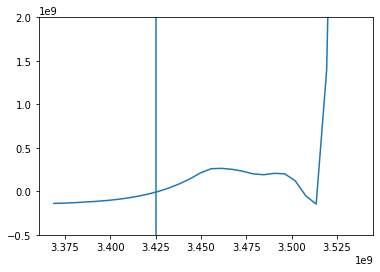

In [12]:
plt.plot(binm,V)
plt.ylim((-5e8,2e9))
plt.axvline(x=bin0)

Calculate PDF using 100 bins

In [13]:
MSE_PDF,PDFedges = np.histogram(RCE300.FMSE,bins=100,density=True)

Calculate evolution of contour over full time period  
tgb - 10/19/2019 - Rewrite the calculation of the contour using the curve library (Julia=https://github.com/tbeucler/2019_WMI/blob/master/dev/tbeucler/009_Julia.py)

In [14]:
dx = 3.3e3
CL = np.zeros((np.size(tcoor),))

for it,t in enumerate(tcoor):
    print('it=',it,'           ',end='\r')
    MSE_tmp = RCE300.FMSE[it,:,:]
    
    MSE_binary = np.zeros(np.shape(MSE_tmp))
    MSE_binary[MSE_tmp>np.median(RCE300.FMSE[it,:,:],axis=(0,1))[np.newaxis,np.newaxis]] = 1

    binary_boundary=np.copy(MSE_binary)
    binary_boundary[:,1:-1]=0

    L = dx*(measure.perimeter(MSE_binary,8)- np.sum(binary_boundary))
        
    CL[it] = L

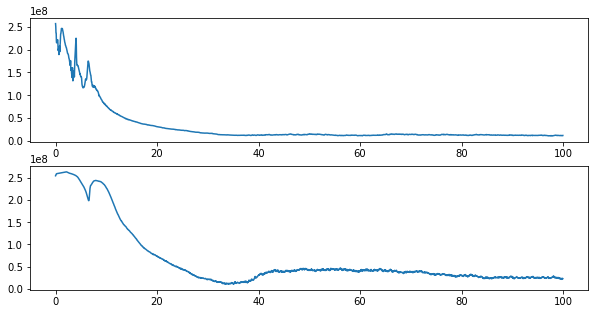

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(tcoor/(24*3600),CL)
plt.subplot(2,1,2)
plt.plot(tcoor/(24*3600),F)

Calculate potential & Landau Free Energy only based on final state (e.g., last month)

In [16]:
bin0_final=np.percentile(a=RCE300.FMSE[-24*30:,:,:],q=50,axis=(0,1,2))

In [17]:
tmp,binm_Vfinal,Vfinal = Landau.Landau_energy(RCE300.FMSE[-24*30:,:,:],dMSE_dt[-24*30:,:,:],bin0,N_bins=30)

In [18]:
Ffinal,binm_Ffinal,tmp = Landau.Landau_energy(RCE300.FMSE,N_bins=30,V_fixed=Vfinal,bin_fixed=binm_Vfinal)

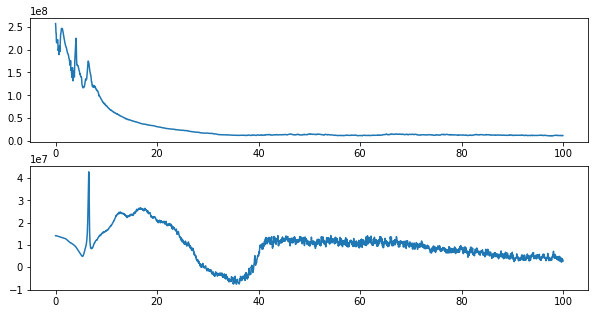

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(tcoor/(24*3600),CL)
plt.subplot(2,1,2)
plt.plot(tcoor/(24*3600),Ffinal)

Recalculate MSE PDFs at three different times to test how they "fill up" the potential

In [20]:
def bin_mid_to_edge(binm):
    bine = 0.5*(binm[:-1]+binm[1:]) # bin_edges[1:-1]
    return np.concatenate(([bine[0]-(bine[2]-bine[1])],bine,[bine[-1]+(bine[2]-bine[1])]))

In [21]:
bine = bin_mid_to_edge(binm)

In [24]:
MSE_PDF_SPIN,SPINe = np.histogram(RCE300.FMSE[:(24*COALstart),:,:],bins=bine,density=True)
MSE_PDF_COAL,COALe = np.histogram(RCE300.FMSE[(24*COALstart):(24*COARstart),:,:],bins=bine,density=True)
MSE_PDF_COAR,COARe = np.histogram(RCE300.FMSE[(24*ENDstart):,:,:],bins=bine,density=True)

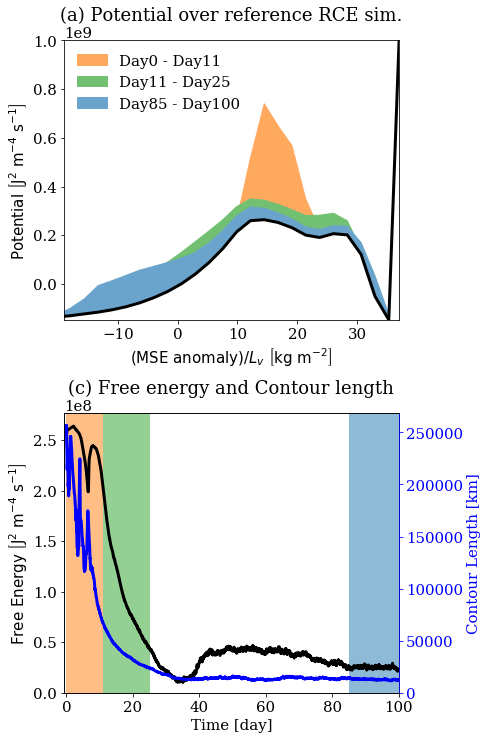

In [30]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

fig,ax = plt.subplots(2,1,figsize=(6,12))
plt.subplots_adjust(hspace=0.33)

ax[0].plot((binm-bin0)/2.5e6,V,color='k')
ax[0].set_xlim((-19,37))
ax[0].set_ylim((-1.5e8,1e9))
ax[0].set_title('(a) Potential over reference RCE sim.',pad=20)
ax[0].set_xlabel(r'$\left(\mathrm{MSE\ anomaly}\right)/L_{v}\ \left[\mathrm{kg\ m^{-2}}\right]$')
ax[0].set_ylabel(r'$\mathrm{Potential\ \left[J^{2}\ m^{-4}\ s^{-1}\right]}$')

ax[0].fill_between((edgTObin(SPINe)-bin0)/2.5e6,V,V+MSE_PDF_SPIN*1e16,color=1-(1-SPINrgb)/1.5,label='Day0 - Day11')
ax[0].fill_between((edgTObin(COALe)-bin0)/2.5e6,V,V+MSE_PDF_COAL*1e16,color=1-(1-COALrgb)/1.5,label='Day11 - Day25')
ax[0].fill_between((edgTObin(COARe)-bin0)/2.5e6,V,V+MSE_PDF_COAR*1e16,color=1-(1-COARrgb)/1.5,label='Day85 - Day100')
ax[0].legend(frameon=False,loc='upper left')

axbis = ax[1].twinx()
axbis.plot(tcoor/(24*3600),CL/1e3,color='b')
axbis.spines['right'].set_color('b')
axbis.tick_params(axis='y', colors='b')
axbis.set_ylim((0,axbis.get_ylim()[1]))
axbis.set_ylabel('Contour Length [km]',color='b')

ax[1].plot(tcoor/(24*3600),F,color='k')

# From https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/fill_between_demo.html
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax[1].transData, ax[1].transAxes)
ax[1].fill_between(x=tcoor/(24*3600),y1=0,y2=1,where=(tcoor/(24*3600)<=11)&(tcoor/(24*3600)>=0),
                   facecolor=SPINrgb,alpha=0.5,transform=trans)
ax[1].fill_between(x=tcoor/(24*3600),y1=0,y2=1,where=(tcoor/(24*3600)<=25)&(tcoor/(24*3600)>=11),
                   facecolor=COALrgb,alpha=0.5,transform=trans)
ax[1].fill_between(x=tcoor/(24*3600),y1=0,y2=1,where=(tcoor/(24*3600)<=100)&(tcoor/(24*3600)>=85),
                   facecolor=COARrgb,alpha=0.5,transform=trans)

ax[1].set_title('(c) Free energy and Contour length',pad=20)
ax[1].set_xlim((-0.75,100))
ax[1].set_ylim((0,ax[1].get_ylim()[1]))
ax[1].set_xlabel('Time [day]')
ax[1].set_ylabel(r'$\mathrm{Free\ Energy\ \left[J^{2}\ m^{-4}\ s^{-1}\right]}$')

# Save figure
path_home = '/users/tbeucler/'
plt.savefig(path_home+'Fig2a.pdf',format='pdf')

In [48]:
import pickle
hf = open('PKL_DATA/10_19_COSMOFig2.pkl','wb')
COSMOFig2_data = {"binm":binm,"bin0":bin0,"V":V,"SPINe":SPINe,"COALe":COALe,"COARe":COARe,\
                 "MSE_PDF_SPIN":MSE_PDF_SPIN,"MSE_PDF_COAL":MSE_PDF_COAL,"MSE_PDF_COAR":MSE_PDF_COAR,\
                 "tcoor":tcoor,"F":F,"CL":CL}
pickle.dump(COSMOFig2_data,hf)
hf.close()

## 2.2) Using CWV percentile that is closest to 48mm

In [15]:
# Define 48mm as value of zero potential
bin0 = 48

In [16]:
# Use the bin edges of coarsened PDF to calculate the potential & Landau Free energy
F,binm,V = Landau.Landau_energy(RCE300.TQV,dTQV_dt,bin0,N_bins=30)

Text(0.5, 0, 't')

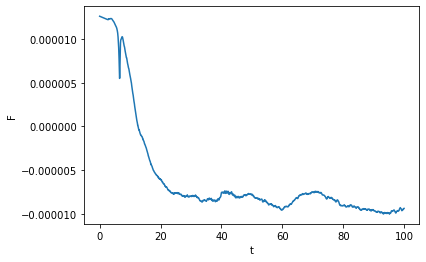

In [17]:
plt.plot(tcoor/(24*3600),F)
plt.ylabel('F')
plt.xlabel('t')

Text(0, 0.5, 'V')

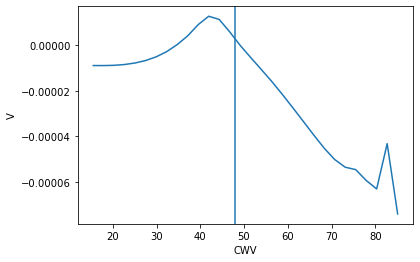

In [18]:
plt.plot(binm,V)
plt.axvline(x=bin0)
plt.xlabel('CWV')
plt.ylabel('V')

Calculate PDF using 100 bins

In [19]:
TQV_PDF,PDFedges = np.histogram(RCE300.TQV,bins=100,density=True)

Calculate contour evolution over full time period using updated Julia script  
[https://github.com/tbeucler/2019_WMI/blob/master/dev/tbeucler/009_Julia.py]

In [20]:
dx = 3.3e3
CL = np.zeros((np.size(tcoor),))

for it,t in enumerate(tcoor):
    print('it=',it,'           ',end='\r')
    TQV_tmp = RCE300.TQV[it,:,:]
    TQV_binary = np.zeros(np.shape(TQV_tmp))
    TQV_binary[TQV_tmp>np.percentile(a=RCE300.TQV[it,:,:],q=MeanPerc48,axis=(0,1))] = 1
    
    binary_boundary = np.copy(TQV_binary)
    binary_boundary[:,1:-1] = 0
    
    Contour = dx*(measure.perimeter(TQV_binary,8)-np.sum(binary_boundary))
    CL[it] = Contour

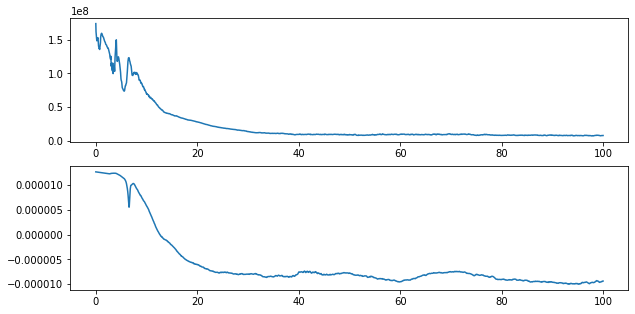

In [21]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(tcoor/(24*3600),CL)
plt.subplot(2,1,2)
plt.plot(tcoor/(24*3600),F)

Recalculate TQV PDF to see how they "fill up" the potential

In [22]:
def bin_mid_to_edge(binm):
    bine = 0.5*(binm[:-1]+binm[1:]) # bin_edges[1:-1]
    return np.concatenate(([bine[0]-(bine[2]-bine[1])],bine,[bine[-1]+(bine[2]-bine[1])]))

In [24]:
bine = bin_mid_to_edge(binm)

In [25]:
TQV_PDF_SPIN,SPINe = np.histogram(RCE300.TQV[:(24*COALstart),:,:],bins=bine,density=True)
TQV_PDF_COAL,COALe = np.histogram(RCE300.TQV[(24*COALstart):(24*COARstart),:,:],bins=bine,density=True)
TQV_PDF_COAR,COARe = np.histogram(RCE300.TQV[(24*ENDstart):,:,:],bins=bine,density=True)

Text(0, 0.5, '$\\mathrm{Free\\ Energy\\ \\left[kg\\ m^{-2}\\ day^{-1}\\right]}$')

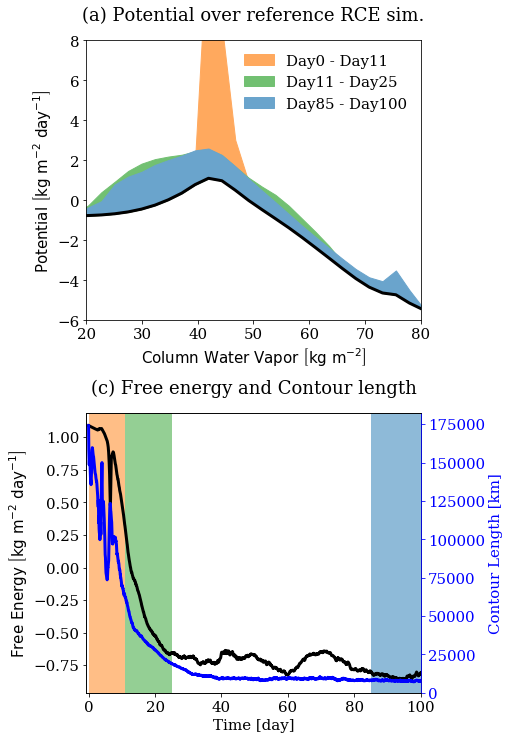

In [51]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

stday = 24*3600

fig,ax = plt.subplots(2,1,figsize=(6,12))
plt.subplots_adjust(hspace=0.33)

ax[0].plot(binm,stday*V,color='k')
ax[0].set_xlim((20,80))
ax[0].set_ylim((-6,8))
ax[0].set_title('(a) Potential over reference RCE sim.',pad=20)
ax[0].set_xlabel(r'$\mathrm{Column\ Water\ Vapor}\ \left[\mathrm{kg\ m^{-2}}\right]$')
ax[0].set_ylabel(r'$\mathrm{Potential\ \left[kg\ m^{-2}\ day^{-1}\right]}$')

ax[0].fill_between(edgTObin(SPINe),stday*V,stday*(V+7.5e-4*TQV_PDF_SPIN),color=1-(1-SPINrgb)/1.5,label='Day0 - Day11')
ax[0].fill_between(edgTObin(COALe),stday*V,stday*(V+7.5e-4*TQV_PDF_COAL),color=1-(1-COALrgb)/1.5,label='Day11 - Day25')
ax[0].fill_between(edgTObin(COARe),stday*V,stday*(V+7.5e-4*TQV_PDF_COAR),color=1-(1-COARrgb)/1.5,label='Day85 - Day100')
ax[0].legend(frameon=False,loc='upper right')

axbis = ax[1].twinx()
axbis.plot(tcoor/stday,CL/1e3,color='b')
axbis.spines['right'].set_color('b')
axbis.tick_params(axis='y', colors='b')
axbis.set_ylim((0,axbis.get_ylim()[1]))
axbis.set_ylabel('Contour Length [km]',color='b')

ax[1].plot(tcoor/stday,stday*F,color='k')

# From https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/fill_between_demo.html
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax[1].transData, ax[1].transAxes)
ax[1].fill_between(x=tcoor/stday,y1=0,y2=1,where=(tcoor/stday<=11)&(tcoor/stday>=0),
                   facecolor=SPINrgb,alpha=0.5,transform=trans)
ax[1].fill_between(x=tcoor/stday,y1=0,y2=1,where=(tcoor/stday<=25)&(tcoor/stday>=11),
                   facecolor=COALrgb,alpha=0.5,transform=trans)
ax[1].fill_between(x=tcoor/stday,y1=0,y2=1,where=(tcoor/stday<=100)&(tcoor/stday>=85),
                   facecolor=COARrgb,alpha=0.5,transform=trans)

ax[1].set_title('(c) Free energy and Contour length',pad=20)
ax[1].set_xlim((-0.75,100))
ax[1].set_xlabel('Time [day]')
ax[1].set_ylabel(r'$\mathrm{Free\ Energy\ \left[kg\ m^{-2}\ day^{-1}\right]}$')

# Save figure
# path_home = '/users/tbeucler/'
# plt.savefig(path_home+'Fig2a.pdf',format='pdf')

In [52]:
# Save reduced data
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
hf = open(pathPKL+'2019_11_19_Fig2ac.pkl','wb')
Fig2ac = {"binm":binm,"bin0":bin0,"V":V,"SPINe":SPINe,"COALe":COALe,"COARe":COARe,\
          "TQV_PDF_SPIN":TQV_PDF_SPIN,"TQV_PDF_COAL":TQV_PDF_COAL,"TQV_PDF_COAR":TQV_PDF_COAR,\
          "tcoor":tcoor,"F":F,"CL":CL}
pickle.dump(Fig2ac,hf)
hf.close()

# 3) Potential decomposition into diabatic contributions & advection

## 3.1) Separate different contributions to total MSE tendency

In [33]:
SEF = -RCE300.SHFL_S - RCE300.LHFL_S

In [34]:
SW = RCE300.ASOB_T-RCE300.ASOB_S

In [35]:
LW = RCE300.ATHB_T-RCE300.ATHB_S

In [36]:
DIAB = LW+SW+SEF

In [37]:
ADV_MSE = dMSE_dt-DIAB

## 3.2) Calculate different contributions of the potential

In [38]:
bin0=np.percentile(a=RCE300.FMSE[-24*7:,:,:],q=50,axis=(0,1,2))

In [39]:
tmp,binm,Vtot = Landau.Landau_energy(RCE300.FMSE,dMSE_dt,bin0,N_bins=30)

In [40]:
hf = open('PKL_DATA/10_19_Vtot.pkl','wb')
V1_data = {"binm":binm,"bin0":bin0,"Vtot":Vtot}
pickle.dump(V1_data,hf)
hf.close()

In [41]:
def bin_mid_to_edge(binm):
    bine = 0.5*(binm[:-1]+binm[1:]) # bin_edges[1:-1]
    return np.concatenate(([bine[0]-(bine[2]-bine[1])],bine,[bine[-1]+(bine[2]-bine[1])]))

In [42]:
tmp,tmp,Vsef = Landau.Landau_energy(RCE300.FMSE,SEF,bin0,N_bins=bin_mid_to_edge(binm))

In [43]:
hf = open('PKL_DATA/10_19_Vsef.pkl','wb')
V2_data = {"binm":binm,"bin0":bin0,"Vsef":Vsef}
pickle.dump(V2_data,hf)
hf.close()

In [44]:
tmp,tmp,Vsw = Landau.Landau_energy(RCE300.FMSE,SW,bin0,N_bins=bin_mid_to_edge(binm))

In [45]:
hf = open('PKL_DATA/10_19_Vsw.pkl','wb')
V3_data = {"binm":binm,"bin0":bin0,"Vsw":Vsw}
pickle.dump(V3_data,hf)
hf.close()

In [46]:
tmp,tmp,Vlw = Landau.Landau_energy(RCE300.FMSE,LW,bin0,N_bins=bin_mid_to_edge(binm))

In [47]:
hf = open('PKL_DATA/10_19_Vlw.pkl','wb')
V4_data = {"binm":binm,"bin0":bin0,"Vlw":Vlw}
pickle.dump(V4_data,hf)
hf.close()

In [48]:
tmp,tmp,Vadv = Landau.Landau_energy(RCE300.FMSE,ADV_MSE,bin0,N_bins=bin_mid_to_edge(binm))

In [49]:
hf = open('PKL_DATA/10_19_Vadv.pkl','wb')
V5_data = {"binm":binm,"bin0":bin0,"Vadv":Vadv}
pickle.dump(V5_data,hf)
hf.close()

In [50]:
X_pot = (binm-bin0)/2.5e6
# Save potentials in .pkl file since they take a long time to calculate
hf = open('PKL_DATA/10_15_VCOSMO.pkl','wb')
V_data = {"X_pot":X_pot,"Vtot":Vtot,"Vsef":Vsef,"Vsw":Vsw,"Vlw":Vlw,"Vadv":Vadv,"binm":binm,"bin0":bin0}
pickle.dump(V_data,hf)
hf.close()

## 3.3) Plot all components of the potential on one plot

In [11]:
hf = open('PKL_DATA/10_15_VCOSMO.pkl','rb')
V_data = pickle.load(hf)
hf.close()

In [13]:
X_pot=V_data["X_pot"]
Vtot=V_data["Vtot"]
Vsef=V_data["Vsef"]
Vsw=V_data["Vsw"]
Vlw=V_data["Vlw"]
Vadv=V_data["Vadv"]
binm=V_data["binm"]
bin0=V_data["bin0"]

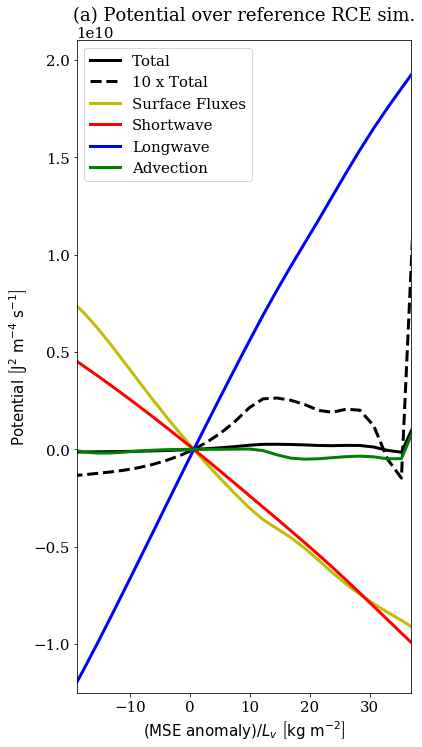

In [22]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

fig,ax = plt.subplots(1,1,figsize=(6,12))
plt.subplots_adjust(hspace=0.33)

X_pot = (binm-bin0)/2.5e6
ax.plot(X_pot,Vtot,color='k',label='Total')
ax.plot(X_pot,10*Vtot,color='k',label='10 x Total',linestyle='--')
ax.plot(X_pot,Vsef,color='y',label='Surface Fluxes')
ax.plot(X_pot,Vsw,color='r',label='Shortwave')
ax.plot(X_pot,Vlw,color='b',label='Longwave')
ax.plot(X_pot,Vadv,color='g',label='Advection')
ax.set_xlim((-19,37))
#ax.set_ylim((-1.5e8,1e9))
ax.set_ylim((-1.25e10,2.1e10))
ax.set_title('(a) Potential over reference RCE sim.',pad=20)
ax.set_xlabel(r'$\left(\mathrm{MSE\ anomaly}\right)/L_{v}\ \left[\mathrm{kg\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{Potential\ \left[J^{2}\ m^{-4}\ s^{-1}\right]}$')
plt.legend()

# Save figure
path_home = '/users/tbeucler/'
plt.savefig(path_home+'A3_a.pdf',format='pdf')